<a href="https://colab.research.google.com/github/GonzaloMA-17/k_brazos_FJLGM/blob/main/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Asignatura**: Extensiones de Machine Learning, 2024/2025

**Alumnos**:<br>
- Gonzalo Marcos Andrés (gonzalo.marcosa@um.es)
- Francisco José López Fernández (franciscojose.lopezf@um.es)

**Máster de Inteligencia Artificial**

| **Facultad de Informática** | **Universidad de Murcia** |
|-----------------------------|---------------------------|
| ![](https://www.um.es/image/layout_set_logo?img_id=175281&t=1726728636242) | ![](https://www.um.es/o/um-lr-principal-um-home-theme/images/logo-um.png) |


<div style="background-color: #e6f7ff; border-left: 6px solid #007acc; padding: 10px; margin-bottom: 10px;">
  <strong>Nota de Aclaración:</strong>  
  <p>Los distintos encabezados no llevan tildes para asegurar el correcto funcionamiento del índice y facilitar la usabilidad del cuaderno.<p>
</div>


# Estudio comparativo de algoritmos en un problema de bandit de k-brazos

[Apartado A](#apartado-a)
- [Preparacion del entorno](#preparacion-del-entorno)  
  - [Clonacion del repositorio](#clonacion-del-repositorio)  
  - [Librerias](#librerias)  
  - [Semilla](#semilla)  
  - [Definicion del experimento](#definicion-del-experimento)

- [Ejecucion del experimento](#ejecucion-del-experimento)  
  - [Visualizacion de resultados](#visualizacion-de-resultados)  
    - [Recompensa Promedio vs Pasos de Tiempo](#recompensa-promedio-vs-pasos-de-tiempo)  
    - [Porcentaje de Seleccion del Brazo Optimo vs Pasos-de-Tiempo](#porcentaje-de-seleccion-del-brazo-optimo-vs-pasos-de-tiempo)  
    - [Estadisticas de seleccion de brazos](#estadisticas-de-seleccion-de-brazos)  
    - [Rechazo acumulado](#rechazo-acumulado)

- [Conclusion](#conclusion)  
  - [Conclusiones Clave](#conclusiones-clave)  
    - [Exploracion vs Explotacion](#exploracion-vs-explotacion)  
    - [Tasa de Aprendizaje](#tasa-de-aprendizaje)  
    - [Recompensa Promedio](#recompensa-promedio)  
    - [Errores y Rechazo Acumulado](#errores-y-rechazo-acumulado)  
    - [Distribucion de Selecciones](#distribucion-de-selecciones)  
  - [Conclusion Final](#conclusion-final)

[Apartado B](#apartado-b)  
- [Analisis de las graficas mas relevantes](#analisis-de-las-graficas-mas-relevantes)  
- [Conclusion](#conclusion)


# **Apartado A**

## Preparacion del entorno

### Clonacion del repositorio:


Para poder acceder a todas las clases y métodos necesarios.

In [1]:
# !git clone https://github.com/GonzaloMA-17/k_brazos_FJLGM.git

In [2]:
%cd k_brazos_FJLGM

[WinError 2] El sistema no puede encontrar el archivo especificado: 'k_brazos_FJLGM'
c:\Users\pacol\Documents\Masters\MasterIA\2-cuatrimestre\Extensiones_de_Machine_Learning\entregas\k_brazos_FJLGM


c:\Users\pacol\Documents\Masters\MasterIA\2-cuatrimestre\Extensiones_de_Machine_Learning\entregas\k_brazos_FJLGM\.venv\lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


### Librerias:

In [3]:
import numpy as np
from typing import List

from src_algorithms import Algorithm, EpsilonGreedy
from src_arms import ArmNormal, Bandit
from src_plotting import *

### Semilla:

In [4]:
seed = 1995

### Definicion del experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado. Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandit de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [5]:
def run_experiment_complete(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    optimal_arm = bandit.optimal_arm
    optimal_reward = bandit.arms[optimal_arm].mu  # Obtener la recompensa esperada del brazo óptimo

    rewards = np.zeros((len(algorithms), steps))  # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.
    arm_rewards = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar las recompensas acumuladas por brazo.
    arm_counts = np.zeros((len(algorithms), bandit.k))  # Matriz para almacenar el número de selecciones por brazo.
    selections_per_algorithm = np.zeros((len(algorithms), bandit.k))  # Matriz para contar selecciones por brazo.
    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz para almacenar el rechazo acumulado.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset()  # Reiniciar los valores de los algoritmos.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()  # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm)  # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward)  # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward  # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                selections_per_algorithm[idx, chosen_arm] += 1

                arm_rewards[idx, chosen_arm] += reward  # Acumular la recompensa obtenida en arm_rewards para el brazo chosen_arm.
                arm_counts[idx, chosen_arm] += 1  # Incrementar el conteo de selecciones para el brazo chosen_arm.

                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Calcular el rechazo acumulado
                regret_accumulated[idx, step] += optimal_reward - reward

    rewards /= runs

    # Calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100

    # Imprimir la cantidad de veces que se seleccionó cada brazo
    print("\nNúmero de veces que fue seleccionado cada brazo:")

    for algo_idx, algo in enumerate(algorithms):
        print(f"\n- Algoritmo {algo_idx} (ε={algo.epsilon}):")
        for arm in range(bandit.k):
            status = "✅ Brazo Óptimo General" if arm == optimal_arm else "No óptimo"
            print(f"   Brazo {arm + 1}: {int(selections_per_algorithm[algo_idx, arm])} veces ({status})")

    # Calcular el promedio de ganancias de cada brazo
    average_rewards = arm_rewards / np.maximum(arm_counts, 1)

    # Calcular el rechazo acumulado promedio
    regret_accumulated = np.cumsum(regret_accumulated, axis=1) / runs

    # Preparar las estadísticas de los brazos
    arm_stats = [{'average_rewards': average_rewards[idx], 'selection_counts': arm_counts[idx]} for idx in range(len(algorithms))]

    return rewards, optimal_selections, arm_stats, regret_accumulated

## Ejecucion del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [ ]:
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandit con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, armStats, regret = run_experiment_complete(bandit, algorithms, steps, runs)

NameError: name 'bandit' is not defined

### Visualizacion de resultados

- Recompensa Promedio vs Pasos de Tiempo
- Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo
- Estadísticas de selección de brazos
- Rechazo acumulado

#### Recompensa Promedio vs Pasos de Tiempo

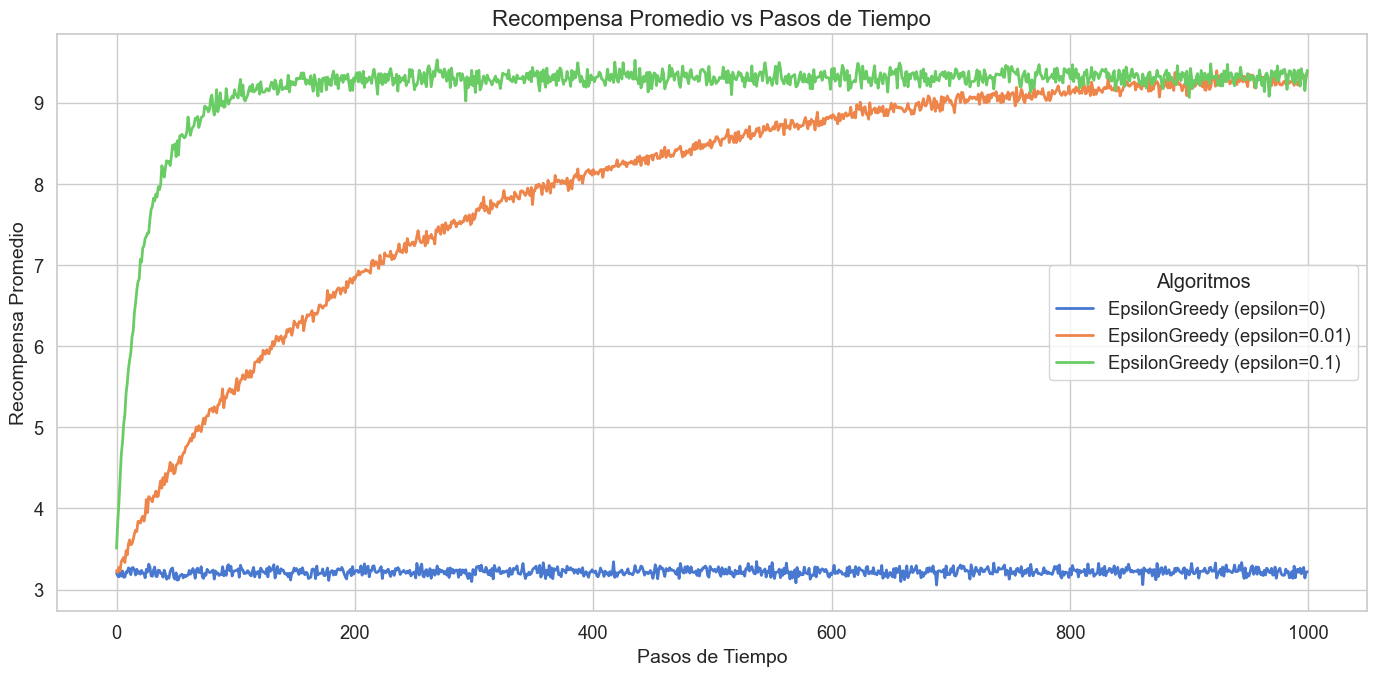

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

**Recompensa Promedio vs Pasos de Tiempo** 

En esta gráfica se analiza el desempeño de diferentes estrategias del algoritmo ``ε-Greedy`` en un entorno de bandit Multibrazos.

- **Ejes**

    - En el ``eje x`` se representan los pasos de tiempo
    - En el ``eje y`` se muestra la recompensa promedio obtenida por cada algoritmo.

Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:

- **Azul** (ε = 0): Representa una estrategia completamente explotadora, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta el momento sin explorar nuevas opciones.  
    - Esta se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.  

- **Naranja** (ε = 0.01): Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
    - Esta también muestra un crecimiento, pero más lento en comparación con ε=0.1.  

- **Verde** (ε = 0.1): Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.
   - Esta alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.


#### Porcentaje de Selección del Brazo Optimo vs Pasos de Tiempo

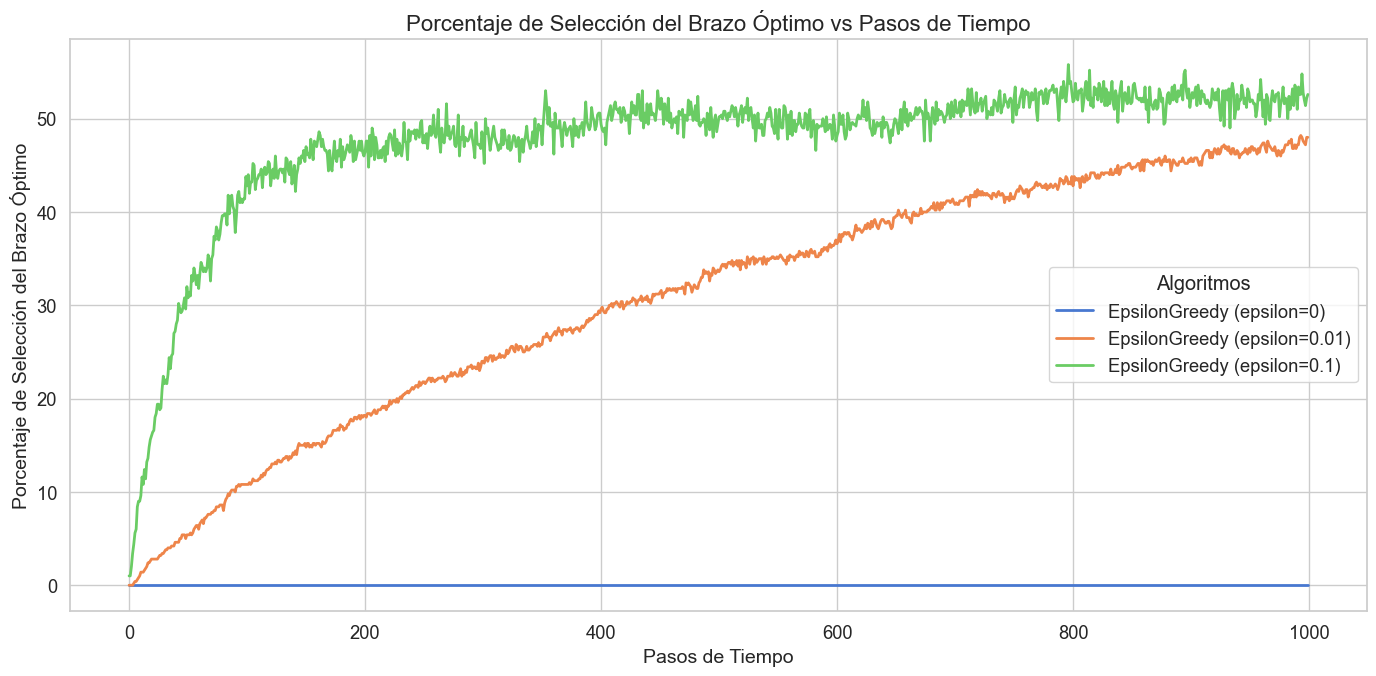

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

**Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo** 

En esta gráfica se analiza el desempeño de diferentes estrategias del algoritmo ``ε-Greedy`` en la selección del brazo óptimo.  

- **Ejes**

    - En el ``eje x`` se representan los **pasos de tiempo**.
    - En el ``eje y`` se muestra el **porcentaje de selección del brazo óptimo** a lo largo del tiempo.

Como en la gráfica anterior, encontramos tres líneas de colores distintos representan diferentes valores de ``ε`` en el algoritmo ``ε-Greedy``:  

- **Azul (ε = 0):** Representa una estrategia completamente explotadora que no realiza exploración, por lo que el porcentaje de selección del brazo óptimo se mantiene cerca de cero.    
    - Si el algoritmo empieza con información deficiente, no corrige su error y **permanece en una opción no óptima**.  
   - La curva se mantiene prácticamente en **0%** de selección del mejor brazo.

- **Naranja (ε = 0.01):** Representa una estrategia con un 1% de exploración, lo que le permite incrementar gradualmente la selección del brazo óptimo con el tiempo.  
    - La curva **asciende** con el tiempo hasta rondar un  casi **50%** de selección del brazo óptimo.  
   - Aprenderá más lento que con un `ε` mayor, pero al menos mejora respecto a la estrategia sin exploración.

- **Verde (ε = 0.1):** Representa una estrategia con un 10% de exploración, lo que le permite encontrar el brazo óptimo rápidamente y mantener un alto porcentaje de selección.  
    - La curva **sube con mayor rapidez** y se estabiliza cerca del **50%** de selección del brazo óptimo, superando claramente a las otras dos.  
   - Esta mayor exploración ayuda a **corregir errores iniciales** y a explotar la opción más rentable.

#### Estadisticas de seleccion de brazos.

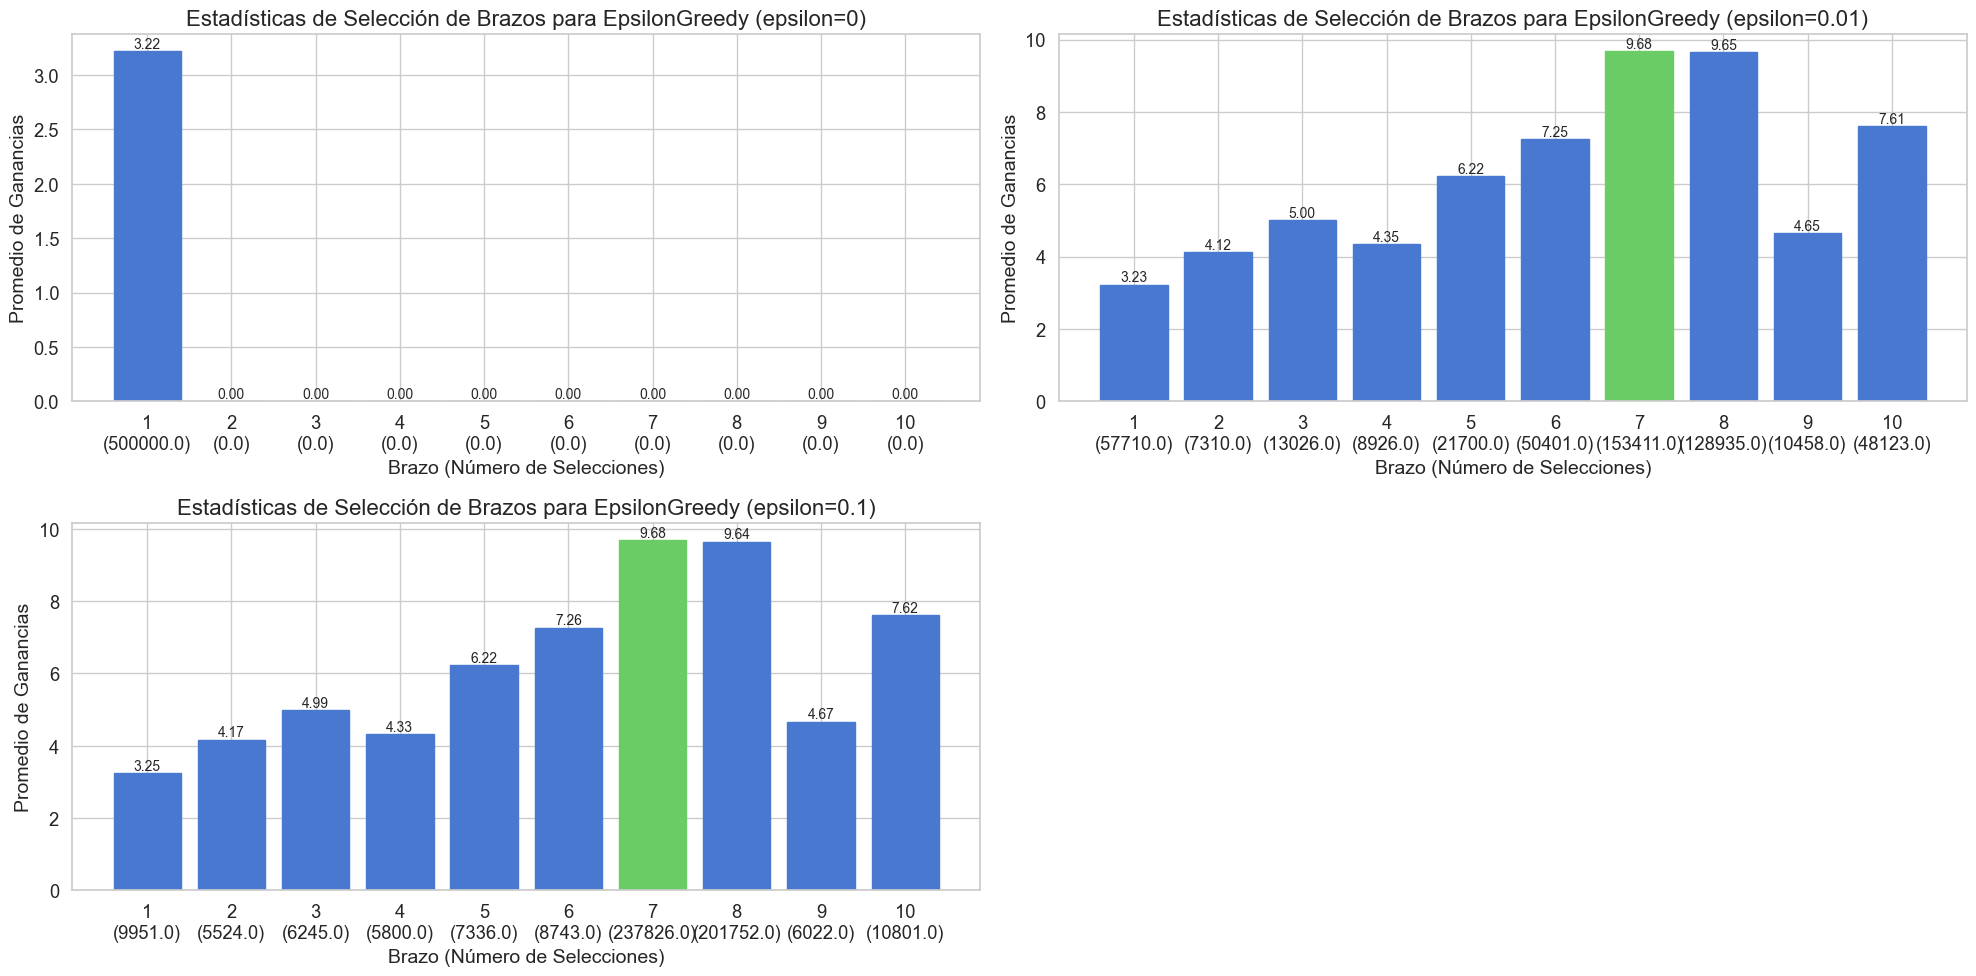

In [ ]:
plot_arm_statistics(armStats, algorithms, optimal_arm)

**Estadísticas de selección de brazos utilizando el algoritmo ``ε-Greedy`` con diferentes valores de `ε`**  

La gráfica representa cómo diferentes valores de `ε` en el algoritmo `ε-Greedy` afectan la selección de brazos, mostrando la frecuencia de selección y el promedio de ganancias de cada brazo.

- **Ejes**
    - En el **eje X**: Los distintos brazos y el número de veces que fueron seleccionados.
    - En el **eje Y**: El promedio de las ganancias obtenidas para cada brazo.  

**Gráficas**
- **Gráfica para ***ε = 0*** (``pura explotación``)  -> Arriba izquierda**
    - Solo explora el primer brazo y nunca prueba los demás.
        - Brazo **0** es seleccionado casi todo el tiempo (**500000 veces**) con una ganancia promedio de (**3.22**).
    - **Nunca prueba otros brazos, lo que lleva a una solución que no es óptima**.

- **Gráfica para ***ε = 0.01*** (``baja exploración``) -> Arriba derecha**
    - Más diversidad en la selección de brazos.
    - El **brazo óptimo (7)** tiene la **mayor ganancia promedio (9.68)** y es el más seleccionado (**153411 veces**, marcado en **verde**).
    - Otros brazos son explorados, pero en menor cantidad.
    - **El algoritmo encuentra el mejor brazo**

- **Gráfica para ε = 0.1 (``más exploración``) -> Abajo**
    - Mayor equilibrio entre exploración y explotación.
    - El **brazo óptimo (9)** es nuevamente el mejor (**9.68**) y se selecciona aún más veces (**237826 veces**).
    - Otros brazos son explorados más que en `ε=0.01`, lo que acelera la identificación del óptimo.
    - **Encuentra la mejor opción más rápido** sin desperdiciar demasiadas pruebas en opciones malas.


#### Rechazo acumulado

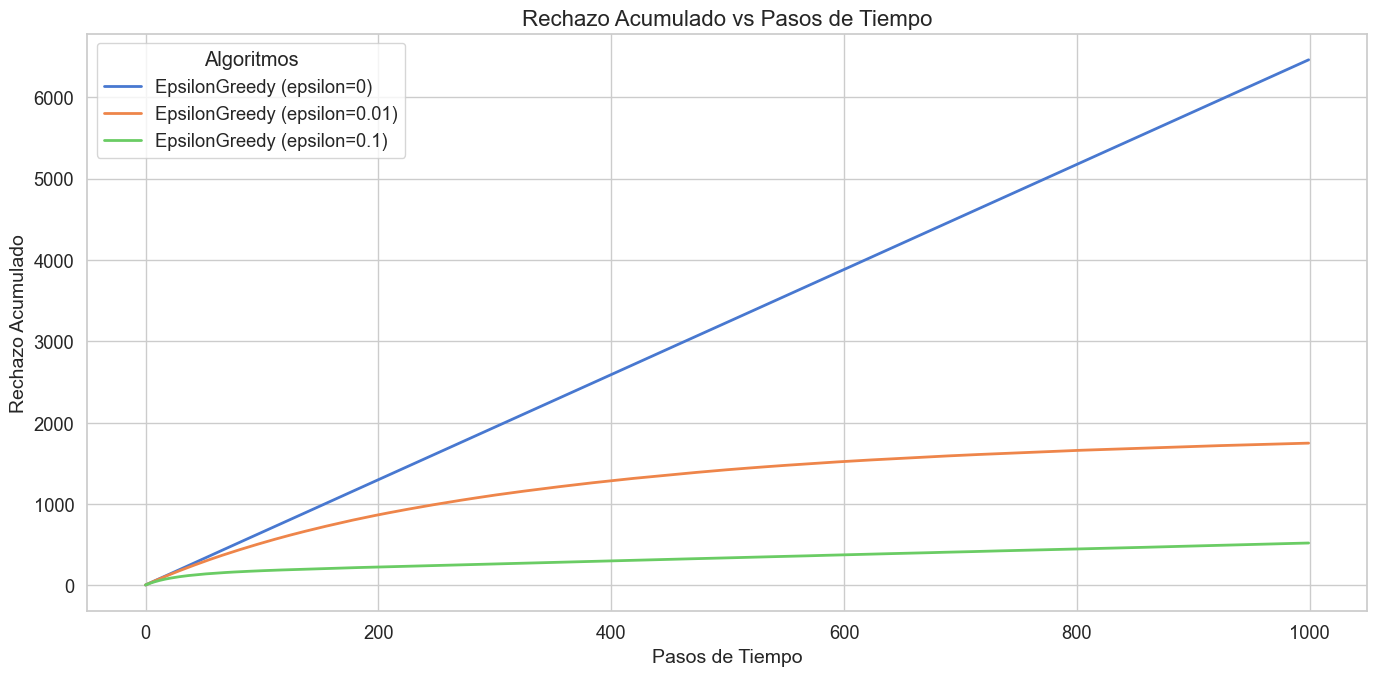

In [ ]:
plot_regret(steps, regret, algorithms)

**Rechazo acumulado**  

Esta gráfica muestra el rechazo acumulado en función del tiempo para diferentes valores de `ε` en el algoritmo **ε-Greedy** representando cómo los distintos niveles de exploración afectan la cantidad de selecciones incorrectas o subóptimas a lo largo de los pasos de tiempo.

**Ejes**
- **Eje X:** Pasos de tiempo (interacciones con el entorno).
- **Eje Y:** Rechazo acumulado (cantidad de selecciones no óptimas).

**Interpretación por cada valor de `ε`**

- **Línea Azul (ε = 0, pura explotación)**
    - **Mayor cantidad de rechazos acumulados.**
    - Dado que este algoritmo **no explora**, si comienza con una mala estimación del mejor brazo, se queda con esa opción indefinidamente.
    - La línea crece de manera **lineal y constante**, indicando que el algoritmo sigue tomando decisiones incorrectas sin corregirse.

- **Línea Naranja (ε = 0.01, exploración baja)**
    - **Mejor comportamiento que `ε=0`, pero aún con bastante rechazo.**
    - Gracias a un bajo nivel de exploración, el algoritmo **corrige sus errores con el tiempo**, reduciendo el ritmo de acumulación de rechazos.
    - Su ritmo de aprendizaje sigue siendo **lento** comparado con valores de `ε` más altos.

- **Línea Verde (ε = 0.1, exploración alta)**
    - **Menor cantidad de rechazos acumulados.**
    - Debido a una mayor exploración, el algoritmo **encuentra el brazo óptimo más rápido**, reduciendo la tasa de rechazos con el tiempo.
    - La curva se aplana pronto, indicando que aprende rápidamente y comete menos errores conforme avanza.


## Conclusion

Este estudio ha evaluado el desempeño del algoritmo **ε-Greedy** en el problema de **bandit Multibrazos (MAB)**, donde un agente debe elegir entre múltiples opciones (*brazos*), con el objetivo de maximizar la recompensa a lo largo del tiempo. Se han comparado tres variantes del algoritmo con diferentes valores de **ε** (`ε=0`, `ε=0.01`, `ε=0.1`), analizando su capacidad para **encontrar la mejor opción, maximizar la recompensa y minimizar errores**.

Los resultados han sido analizados a través de varias métricas, incluyendo:

- Porcentaje de selección del brazo óptimo.
- Recompensa promedio acumulada.
- Errores cometidos (rechazo acumulado).
- Distribución de selecciones de brazos.

### Conclusiones Clave

#### Exploracion vs Explotacion

El parámetro `ε` determina el equilibrio entre exploración y explotación dentro del algoritmo:

- **`ε=0` (Sin exploración):**  
  El agente siempre elige la mejor opción que conoce, pero si comienza con información deficiente, puede quedar atascado en una decisión subóptima.

- **`ε=0.01` (Exploración baja):**  
  Introduce un ligero grado de aleatoriedad, permitiendo corregir errores con el tiempo, aunque de forma más lenta.

- **`ε=0.1` (Exploración moderada):**  
  Incrementa la frecuencia de búsqueda de nuevas opciones, favoreciendo el hallazgo rápido del mejor brazo y la reducción de errores.

En conclusión, un **nivel de exploración moderado (`ε=0.1`)** ofrece un **aprendizaje más eficiente** y **maximiza las recompensas** a largo plazo.


#### Tasa de Aprendizaje

La gráfica de selección del brazo óptimo muestra la rapidez con la que cada variante del algoritmo encuentra la mejor opción:

| Estrategia   | % Selección del Óptimo (aprox.) | Velocidad de Aprendizaje |
|--------------|---------------------------------|--------------------------|
| **ε = 0**    | ~0%                             | No mejora con el tiempo  |
| **ε = 0.01** | ~40%                            | Lento                    |
| **ε = 0.1**  | ~50%                            | Rápido                   |

El algoritmo con `ε=0.1` encuentra el brazo óptimo más rápido y con mayor consistencia.

#### Recompensa Promedio

El gráfico de recompensa promedio vs pasos de tiempo revela que:

- `ε=0.1` alcanza la mayor recompensa (~9.5) y la mantiene.
- `ε=0.01` mejora con el tiempo, pero su curva de aprendizaje es más lenta.
- `ε=0` se estanca en recompensas bajas (~3) porque nunca explora.

Explorar más al inicio permite encontrar estrategias más rentables a largo plazo.

#### Errores y Rechazo Acumulado

El gráfico de rechazo acumulado mide cuántas veces el algoritmo toma una decisión incorrecta:

| Estrategia  | Errores Cometidos | Capacidad de Corrección |
|------------|------------------|------------------------|
| **ε = 0**  | Muchos           | Nunca mejora          |
| **ε = 0.01** | Intermedios      | Corrige lentamente   |
| **ε = 0.1**  | Menos errores    | Aprende y mejora rápido |

Un mayor `ε` reduce significativamente los errores cometidos al permitir que el algoritmo corrija sus decisiones iniciales.

#### Distribucion de Selecciones

El análisis de estadísticas de selección de brazos confirma que:

- `ε=0` solo elige 2 brazos y nunca prueba los demás.
- `ε=0.01` explora más opciones, pero aún evita algunos brazos.
- `ε=0.1` explora adecuadamente y encuentra el brazo óptimo.

Explorar más permite descubrir todas las opciones y tomar decisiones informadas.

### Conclusion Final

A partir del estudio realizado, se concluye que:

1. Un **ε demasiado bajo (`ε=0`) es ineficiente**, ya que **no explora y nunca encuentra la mejor opción**.  
2. Un **ε pequeño (`ε=0.01`) mejora con el tiempo, pero a un ritmo lento**.  
3. Un **ε más alto (`ε=0.1`) logra el mejor equilibrio**, **aprendiendo rápido, reduciendo errores y maximizando recompensas**.  

En problemas de **optimización de decisiones** (publicidad, sistemas de recomendación, optimización de recursos), una **estrategia de exploración moderada** (`ε=0.1`) es ideal para garantizar que el agente aprenda la mejor opción en el menor tiempo posible.

El balance entre exploración y explotación es clave para maximizar la recompensa a largo plazo.

# **Aparatado B**

Indique qué gráficas son las más relevantes ¿por qué?

## Analisis de las graficas mas relevantes

En el estudio de un problema de bandit Multibrazos, es crucial entender cómo evolucionan las decisiones del algoritmo a lo largo del tiempo. Para ello, ciertas representaciones gráficas aportan información fundamental sobre su desempeño y capacidad de aprendizaje.

- **1. Recompensa Promedio vs Pasos de Tiempo**

Esta gráfica permite observar la **velocidad de aprendizaje** del algoritmo y el **nivel máximo de recompensa** que logra alcanzar.  
    - **Rapidez de convergencia**: Cuán rápido la curva asciende hasta estabilizarse indica lo pronto que el algoritmo descubre y aprovecha el brazo óptimo.  
    - **Rendimiento final**: El valor al que se estabiliza la curva sugiere la calidad de la solución encontrada. Un algoritmo efectivo alcanzará recompensas más altas en menos tiempo.


- **2. Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo**

Mientras la recompensa promedio muestra el **resultado** (cuánto gana), esta gráfica indica la **frecuencia** con la que el algoritmo elige la mejor opción.  
    - **Identificación del brazo óptimo**: Un porcentaje creciente indica que el algoritmo aprende a reconocer y explotar la opción más rentable.  
    - **Nivel de exploración**: Si el porcentaje permanece bajo o crece muy lentamente, puede sugerir que la estrategia de exploración es insuficiente (o, en casos opuestos, que se explora demasiado y no se explota lo aprendido).

## Conclusion

Aunque otras gráficas (como la de **estadísticas de selección de brazos** o la de **rechazo acumulado**) también ofrecen datos valiosos para el diagnóstico, la **Recompensa Promedio** y el **Porcentaje de Selección del Brazo Óptimo** son los indicadores más directos y completos de la eficacia de un algoritmo en un escenario de bandit Multibrazos. 

El primero evidencia el **nivel de rendimiento** alcanzado, mientras que el segundo confirma **qué tan consistentemente** se elige la opción más provechosa. Conjugados, ambos ofrecen una visión integral de la **capacidad de aprendizaje** y la **velocidad de convergencia** del método analizado.